# Weather Prediction Model

# 1. Import Libraries:

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime
import re
from groq import Groq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import joblib
from dotenv import load_dotenv  
import os                       

# 2. Load Dataset:

In [7]:
data = pd.read_csv(r"D:\Weather Prediction Model Data\weatherHistory.csv\weatherHistory.csv")

# Preview columns and data
print(data.columns.tolist())
print(data.head())

['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover', 'Pressure (millibars)', 'Daily Summary']
                  Formatted Date        Summary Precip Type  Temperature (C)  \
0  2006-04-01 00:00:00.000 +0200  Partly Cloudy        rain         9.472222   
1  2006-04-01 01:00:00.000 +0200  Partly Cloudy        rain         9.355556   
2  2006-04-01 02:00:00.000 +0200  Mostly Cloudy        rain         9.377778   
3  2006-04-01 03:00:00.000 +0200  Partly Cloudy        rain         8.288889   
4  2006-04-01 04:00:00.000 +0200  Mostly Cloudy        rain         8.755556   

   Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                  7.388889      0.89            14.1197   
1                  7.227778      0.86            14.2646   
2                  9.377778      0.89             3.9284   
3                  5.944444      0.83            14.10

# 3. Data Cleaning & Preprocessing:

In [10]:
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], utc=True, errors='coerce')
# Drop rows that could not be converted
data = data.dropna(subset=['Formatted Date'])
# Forward-fill missing values (updated syntax)
data.ffill(inplace=True)
# Ensure numeric columns are correct type
numeric_cols = ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
                'Wind Speed (km/h)', 'Pressure (millibars)', 'Visibility (km)']
for col in numeric_cols:
    data[col] = data[col].astype(float)
# Map textual summaries to weather categories
def map_weather(summary):
    summary = summary.lower()
    if "rain" in summary or "drizzle" in summary:
        return "Rain"
    elif "snow" in summary:
        return "Snow"
    elif "cloudy" in summary:
        return "Cloudy"
    elif "clear" in summary:
        return "Clear"
    elif "fog" in summary:
        return "Foggy"
    else:
        return "Other"
data['Weather'] = data['Daily Summary'].apply(map_weather)


# 4. Feature Engineering:

In [12]:
# Convert 'Formatted Date' to datetime with timezone handling
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], utc=True, errors='coerce')
# Check for conversion issues
num_invalid = data['Formatted Date'].isna().sum()
print(f"{num_invalid} rows could not be converted to datetime")
# Drop rows where datetime conversion failed
data = data.dropna(subset=['Formatted Date'])
# Extract time features
data['Hour'] = data['Formatted Date'].dt.hour
data['Day'] = data['Formatted Date'].dt.day
data['Month'] = data['Formatted Date'].dt.month
data['Year'] = data['Formatted Date'].dt.year
# Verify
print(data[['Formatted Date', 'Hour', 'Day', 'Month', 'Year']].head())


0 rows could not be converted to datetime
             Formatted Date  Hour  Day  Month  Year
0 2006-03-31 22:00:00+00:00    22   31      3  2006
1 2006-03-31 23:00:00+00:00    23   31      3  2006
2 2006-04-01 00:00:00+00:00     0    1      4  2006
3 2006-04-01 01:00:00+00:00     1    1      4  2006
4 2006-04-01 02:00:00+00:00     2    1      4  2006


# 5. Data Visualization:

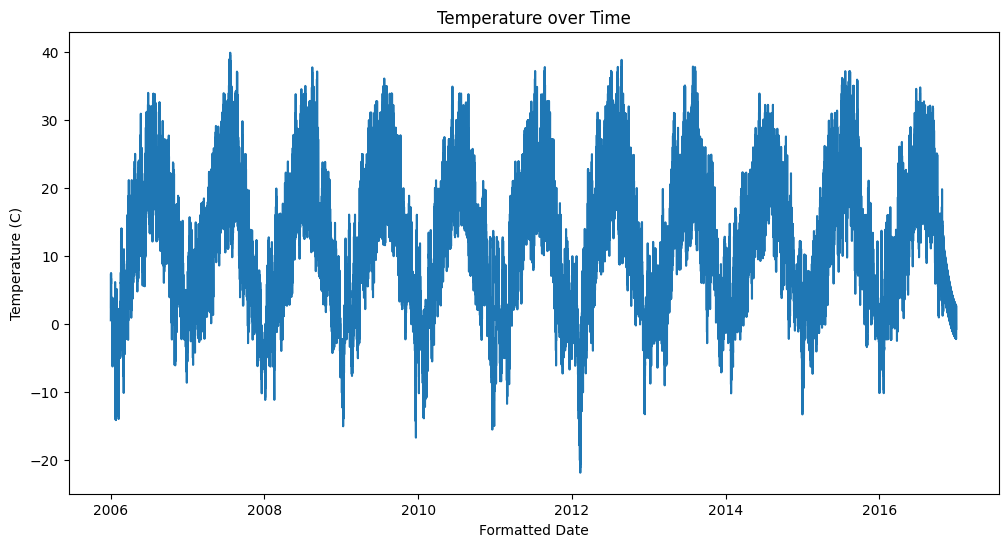

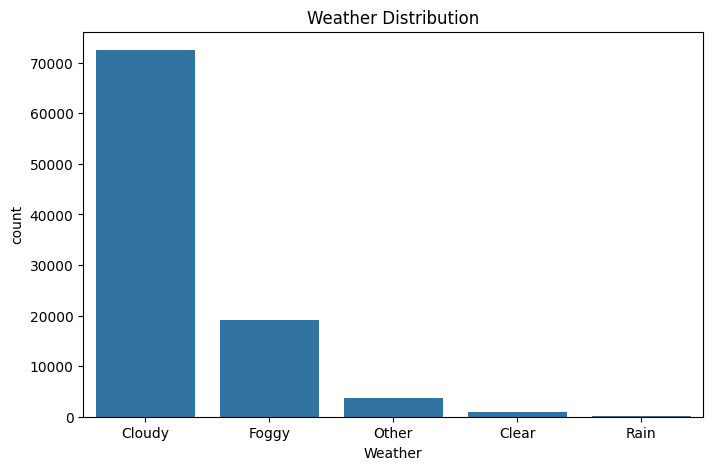

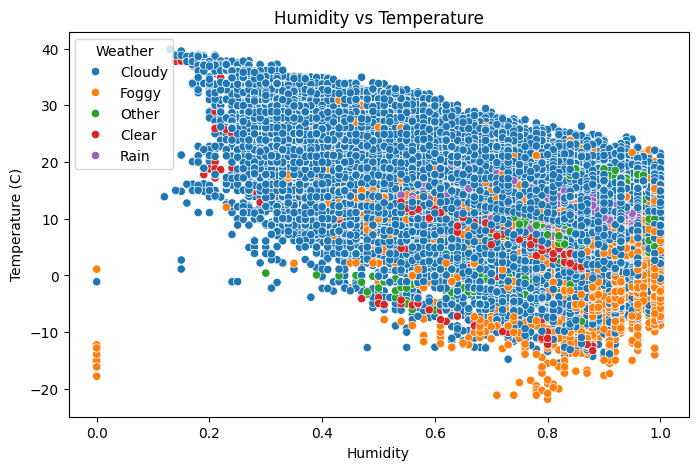

In [16]:
# Temperature over time
plt.figure(figsize=(12,6))
sns.lineplot(x='Formatted Date', y='Temperature (C)', data=data)
plt.title("Temperature over Time")
plt.show()

# Weather distribution
plt.figure(figsize=(8,5))
sns.countplot(x='Weather', data=data)
plt.title("Weather Distribution")
plt.show()

# Humidity vs Temperature
plt.figure(figsize=(8,5))
sns.scatterplot(x='Humidity', y='Temperature (C)', hue='Weather', data=data)
plt.title("Humidity vs Temperature")
plt.show()

# 6. Model Development:

In [18]:
features = ['Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Pressure (millibars)',
            'Year', 'Month', 'Day', 'Hour']  
X = data[features]
y = data['Weather']
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# Initialize and train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# 7. Model Evaluation:

Accuracy: 0.9233321237882951

Classification Report:
               precision    recall  f1-score   support

       Clear       0.90      0.34      0.49       187
      Cloudy       0.93      0.98      0.95     14473
       Foggy       0.90      0.80      0.85      3837
       Other       0.95      0.58      0.72       748
        Rain       0.89      0.70      0.78        46

    accuracy                           0.92     19291
   macro avg       0.91      0.68      0.76     19291
weighted avg       0.92      0.92      0.92     19291



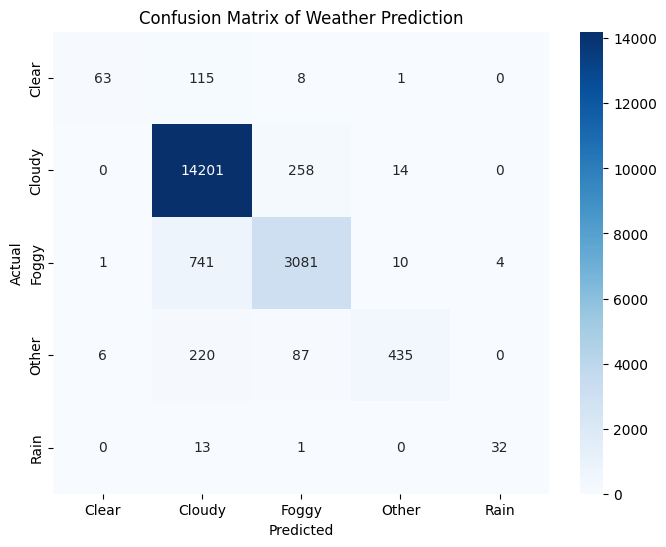

In [21]:
y_pred = clf.predict(X_test)
# Classification metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
# Confusion matrix (better for categorical data)
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=clf.classes_, yticklabels=clf.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Weather Prediction')
plt.show()

# 8. Save the Model:

In [25]:
joblib.dump(clf, "weather_prediction_model.pkl")
print("Model saved as 'weather_prediction_model.pkl'")

Model saved as 'weather_prediction_model.pkl'


# Store API Keys:

In [28]:
from dotenv import load_dotenv
import os

# Load the .env file
load_dotenv("C:/Users/Hp/Documents/.env")

# Get API keys
openweather_api_key = os.getenv("OPENWEATHER_API_KEY")
groq_api_key = os.getenv("GROQ_API_KEY")

# Live Weather Data Integeration:

In [31]:
load_dotenv()
# 1. API Key from environment variable
API_KEY = os.getenv("OPENWEATHER_API_KEY")

if not API_KEY:
    raise ValueError("OPENWEATHER_API_KEY is not set in the environment variables.")

# Function to get live weather data
def get_live_weather(city):
    try:
        url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}&units=metric"
        response = requests.get(url)
        response.raise_for_status()  # Raise error if request fails
        data = response.json()
        features = [
            data["main"]["feels_like"],      # Apparent Temperature
            data["main"]["humidity"],        # Humidity
            data["wind"]["speed"],           # Wind Speed
            data["main"]["pressure"],        # Pressure
        ]
        return features
    except Exception as e:
        print(f"Error fetching data for {city}: {e}")
        return None

# Load trained model
model = joblib.load("weather_prediction_model.pkl")

# Predict weather for a city
city = "Karachi"
features = get_live_weather(city)

if features is not None:
    now = datetime.datetime.utcnow()

    # Convert features to DataFrame with proper column names
    live_features = {
        'Apparent Temperature (C)': [features[0]],
        'Humidity': [features[1]],
        'Wind Speed (km/h)': [features[2]],
        'Pressure (millibars)': [features[3]],
        'Year': [now.year],
        'Month': [now.month],
        'Day': [now.day],
        'Hour': [now.hour]
    }

    X_live = pd.DataFrame(live_features)

    # Predict using trained model
    prediction = model.predict(X_live)
    print(f"Predicted weather in {city}:", prediction[0])
else:
    print("Could not fetch live weather data.")

Predicted weather in Karachi: Cloudy


# Initialize with GROQ API key:

In [34]:
client = Groq(api_key=groq_api_key)


# function to handle weather queries:

In [37]:
def get_live_weather(city):
    url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={openweather_api_key}&units=metric"
    response = requests.get(url)
    if response.status_code != 200:
        return None
    data = response.json()
    temp = data['main']['feels_like']
    humidity = data['main']['humidity']
    wind_speed = data['wind']['speed']
    pressure = data['main']['pressure']
    return [temp, humidity, wind_speed, pressure]

# 4. Weather chat function
def weather_chat(query):
    """
    Handles user queries about the weather using live data + trained model + Groq LLM.
    """
    # Extract city from query
    if "in" in query:
        city = query.split("in")[-1].strip()
        city = re.sub(r"\b(today|now)\b", "", city, flags=re.IGNORECASE).strip()
    else:
        city = "London"

    # Fetch live weather
    features = get_live_weather(city)
    if features is None:
        return f"Could not fetch live weather data for {city}."

    # Add datetime features
    now = datetime.datetime.utcnow()
    features += [now.year, now.month, now.day, now.hour]

    # Convert to DataFrame for model input
    live_features = {
        'Apparent Temperature (C)': [features[0]],
        'Humidity': [features[1]],
        'Wind Speed (km/h)': [features[2]],
        'Pressure (millibars)': [features[3]],
        'Year': [now.year],
        'Month': [now.month],
        'Day': [now.day],
        'Hour': [now.hour]
    }
    X_live = pd.DataFrame(live_features)

    # Predict weather category using trained model
    prediction = model.predict(X_live)[0]

    # Prepare answer string
    answer = f"Today in {city}, the temperature is {features[0]}°C, humidity {features[1]}%, and predicted weather: {prediction}."

    # Send query + answer to Groq LLM
    chat_completion = client.chat.completions.create(
        messages=[
            {"role": "assistant", "content": answer},  # Assistant context first
            {"role": "user", "content": query}         # User query last
        ],
        model="compound-beta"
    )

    # Return LLM response text
    return chat_completion.choices[0].message.content

# 5. Example usage:
print(weather_chat("Tell me the weather in India today"))

The current weather in India today is characterized by high temperatures, high humidity, and moderate to heavy rainfall across different regions. 

In New Delhi, the temperature is around 31.2°C (88.2°F) with moderate or heavy rain and thunder. 
In Varanasi, Uttar Pradesh, the weather forecast is available, but specific current weather conditions are not provided.
In Punjab, the temperature ranges from 26°C to 34°C (77.9°F to 93.9°F) with scattered clouds.
In Mumbai, the temperature ranges between 26.4°C and 27.9°C (79.5°F and 82.2°F) with high humidity and moderate rainfall.
In Kolkata, the temperature ranges between 26.6°C and 31°C (79.9°F and 87.8°F) with high humidity and moderate rainfall.

Overall, the weather in India today is hot and rainy, with temperatures ranging from 26°C to 34°C (77.9°F to 93.9°F) and humidity levels ranging from 75% to 84%.
